In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_22844/2292707060.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [67]:
ds_version = "weseraue"
# annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "prediction")
# only_validation = True
confidence_threshold = 0.9

saving_name = "blur_weseraue_results.csv"

In [3]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [4]:
# annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
# annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true"}, inplace=True)
# annot = annot[(annot.train == True)]

# print(annot)

In [72]:
df_blur_orig = pd.DataFrame(
    {"kernel": [0, 5, 5, 5, 7, 7, 7, 9, 9, 9, 11, 11, 11],
     "sigma": [0, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5],
     "model_dataset": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    },
)

# df_blur = pd.DataFrame(
#     {"kernel": [0, 5, 7, 9, 11, 5, 7, 9, 11, 5, 7, 9, 11],
#      "sigma": [0, 2, 2, 2, 2, 3.5, 3.5, 3.5, 3.5, 5, 5, 5, 5],
#     },
# )

df_blur = pd.DataFrame(
    {"kernel": [0, 5, 5, 5, 7, 7, 7, 9, 9, 9, 11, 11, 11],
     "sigma": [0, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5],
    },
)


gm_valid = np.zeros((df_blur.shape[0], 1))
gm_valid_high_conf = np.zeros((df_blur.shape[0], 1))

cm_valid = np.zeros((df_blur.shape[0], 5, 5), dtype=int)
cm_valid_high_conf = np.zeros((df_blur.shape[0], 5, 5), dtype=int)

classification = pd.DataFrame()


yticklabels = []
xticklabels = ["weseraue"]

for index_y, row_m in df_blur.iterrows():
    index_m = df_blur_orig[(df_blur_orig["kernel"]==row_m['kernel']) & (df_blur_orig["sigma"]==row_m['sigma'])]["model_dataset"].values[0]
    # print(index_m)
    yticklabels.append(f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}")
    
    # kernel = row_d["kernel"] if row_d["kernel"] != 0 else None
    # sigma = row_d["sigma"] if row_d["sigma"] != 0 else None
    name = f"effnet_blur_surface_pred_weseraue_model{index_m}-"
    pred_file = ""
    for root, _, fnames in sorted(os.walk(data_path, followlinks=False)):
        for fname in sorted(fnames):
            if name in fname and fname.endswith('.csv'):
                pred_file = os.path.join(root, fname)
                # print(pred_file)
    if pred_file == "":
        raise ValueError(f"no prediction file found for model {index_m}")
    
    pred = pd.DataFrame()

    # print(f"reading {pred_file}")
    pred = pd.read_csv(pred_file)
    pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

    pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
    pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
    idx = pred.groupby("image_id")["class_prob"].idxmax()
    type_pred = pred.loc[idx].reset_index()
    pred = pred[pred["type_pred"] == "paving_stones"]
    
    type_pred["type_true"] = "paving_stones"
    df = type_pred.set_index("image_id")
    df_high_conf = df[df["class_prob"]>confidence_threshold]
    
    gm = compute_measures_cat(df.type_true, df.type_pred)
    gm_valid[index_y] = round(gm['accuracy'], 3)
    gm_high_conf = compute_measures_cat(df_high_conf.type_true, df_high_conf.type_pred)
    gm_valid_high_conf[index_y] = round(gm_high_conf['accuracy'], 3)

    cm = confusion_matrix(df.type_true, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    cm_valid[index_y, :, :] = cm
    cm_high_conf = confusion_matrix(df_high_conf.type_true, df_high_conf.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    cm_valid_high_conf[index_y, :, :] = cm_high_conf

    # misclassification
    if (index_m == 0):
        classification["image_id"] = type_pred["image_id"]
        classification["type_true"] = type_pred["type_true"]
        classification.set_index("image_id", inplace=True)
        # classification = classification.join(type_pred[["image_id"]].set_index("image_id"), how="left")

    column = f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}"
    type_pred.rename(columns={"type_pred": f"{column}_class", "class_prob": f"{column}_prob"}, inplace=True)
    pred.rename(columns={"class_prob": f"{column}_ps_prob"}, inplace=True)
    classification = classification.join(type_pred[["image_id", f"{column}_class", f"{column}_prob"]].set_index("image_id"), how="left")
    classification = classification.join(pred[["image_id", f"{column}_ps_prob"]].set_index("image_id"), how="left")
    
# classification.to_csv(os.path.join(data_path, "model_predictions", "classification_blur.csv"), index=True)


In [73]:
# classification

In [74]:
class_columns = [col for col in classification.columns if 'class' in col]

classification['paving_stones_count'] = classification[class_columns].apply(lambda row: (row == 'paving_stones').sum(), axis=1)

classification['paving_stones_percentage'] = classification['paving_stones_count'] / len(class_columns) * 100
classification.to_csv(os.path.join(data_path, "analysis", saving_name), index=True)
classification

,type_true,model_k_None_s_None_class,model_k_None_s_None_prob,model_k_None_s_None_ps_prob,model_k_5.0_s_2.0_class,model_k_5.0_s_2.0_prob,model_k_5.0_s_2.0_ps_prob,model_k_5.0_s_3.5_class,model_k_5.0_s_3.5_prob,model_k_5.0_s_3.5_ps_prob,...,model_k_11.0_s_2.0_prob,model_k_11.0_s_2.0_ps_prob,model_k_11.0_s_3.5_class,model_k_11.0_s_3.5_prob,model_k_11.0_s_3.5_ps_prob,model_k_11.0_s_5.0_class,model_k_11.0_s_5.0_prob,model_k_11.0_s_5.0_ps_prob,paving_stones_count,paving_stones_percentage
image_id,,,,,,,,,,,,,,,,,,,,,
1003421317011254_1,paving_stones,asphalt,0.998831,0.000745,asphalt,0.994256,0.001416,asphalt,0.929252,0.020974,...,0.987952,0.003989,asphalt,0.881701,0.046285,asphalt,0.785054,0.115188,0,0.000000
1004648970243129_1,paving_stones,asphalt,0.979659,0.012926,asphalt,0.757303,0.170732,asphalt,0.687985,0.247986,...,0.516142,0.304550,asphalt,0.352637,0.311049,paving_stones,0.789244,0.789244,5,38.461538
1005094273511271_1,paving_stones,asphalt,0.894104,0.019524,asphalt,0.903033,0.017953,asphalt,0.816897,0.003829,...,0.678853,0.020550,unpaved,0.579797,0.023371,unpaved,0.650317,0.015809,0,0.000000
1006890656687898_1,paving_stones,paving_stones,0.999734,0.999734,paving_stones,0.999950,0.999950,paving_stones,0.999927,0.999927,...,0.999967,0.999967,paving_stones,0.999660,0.999660,paving_stones,0.999458,0.999458,13,100.000000
1007165086631803_1,paving_stones,unpaved,0.841003,0.001656,unpaved,0.791943,0.049677,unpaved,0.816730,0.003368,...,0.856581,0.012165,unpaved,0.938289,0.002276,unpaved,0.862854,0.000860,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990912734900915_1,paving_stones,asphalt,0.984099,0.004037,asphalt,0.965360,0.011323,asphalt,0.969360,0.014383,...,0.984839,0.004727,asphalt,0.914803,0.034232,asphalt,0.913959,0.026401,0,0.000000
992057481461356_1,paving_stones,asphalt,0.897239,0.100048,asphalt,0.449547,0.291663,paving_stones,0.472639,0.472639,...,0.430500,0.430500,asphalt,0.461766,0.364494,paving_stones,0.921775,0.921775,6,46.153846
994533647929913_1,paving_stones,paving_stones,0.843193,0.843193,paving_stones,0.626927,0.626927,paving_stones,0.515126,0.515126,...,0.741100,0.161883,asphalt,0.541908,0.257646,sett,0.469604,0.463760,6,46.153846


In [75]:
count_frequencies = classification['paving_stones_count'].value_counts().sort_index()
normalized_frequencies = count_frequencies / count_frequencies.sum()
# print("Häufigkeit der verschiedenen Count-Werte:")
# print(count_frequencies)
# print(normalized_frequencies)

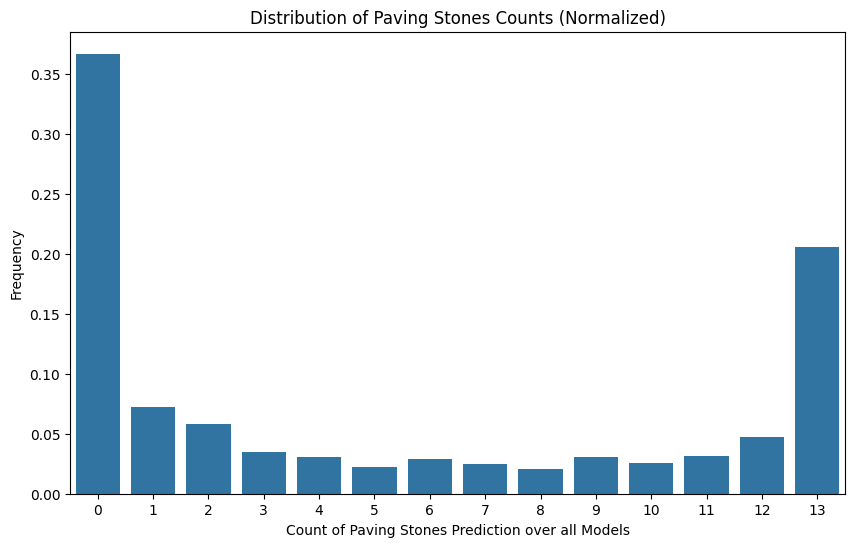

In [76]:
plt.figure(figsize=(10, 6))
# sns.histplot(classification['paving_stones_count'], bins=len(class_columns)+1, kde=True, stat="density")
sns.barplot(x=normalized_frequencies.index, y=normalized_frequencies.values)
plt.title('Distribution of Paving Stones Counts (Normalized)')
plt.xlabel('Count of Paving Stones Prediction over all Models')
plt.ylabel('Frequency')
plt.xticks(range(0, len(class_columns)+1))
plt.show()

In [12]:
gm_valid.shape

(13, 1)

In [30]:
# cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

# plt.figure()
# sns.heatmap(gm_valid*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
#             xticklabels=xticklabels,
#             yticklabels=yticklabels)
# plt.title(f"Accuracy for blur models and datasets")
# plt.xlabel("dataset")
# plt.ylabel("model")
# # plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
# plt.show()

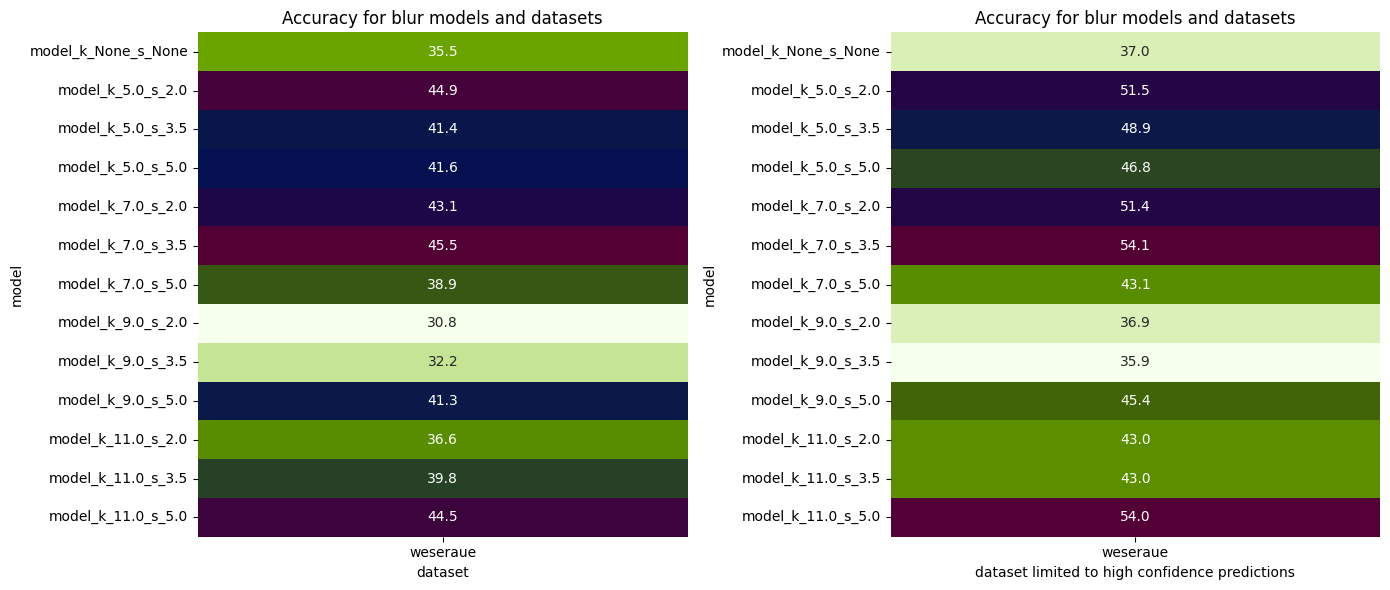

In [77]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(gm_valid*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax[0])
ax[0].set_title(f"Accuracy for blur models and datasets")
ax[0].set_xlabel("dataset")
ax[0].set_ylabel("model")
sns.heatmap(gm_valid_high_conf*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax[1])
ax[1].set_title(f"Accuracy for blur models and datasets")
ax[1].set_xlabel("dataset limited to high confidence predictions")
ax[1].set_ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Confusion Matrix

In [78]:
def plot_conf_matrix(cm, model, dataset):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    plt.title(f"Confusion Matrix for model {model} and dataset {dataset}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

In [79]:
def plot_conf_matrix_2(cm_1, cm_2, model, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[0])
    ax[0].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Annotated")
    sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[1])
    ax[1].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[1].set_xlabel(f"Predicted with probability > {confidence_threshold}")
    ax[1].set_ylabel("Annotated")
    plt.tight_layout()
    plt.show()

In [80]:
def plot_prob_hist(col1, col2, model, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(col1, stat="density", ax=ax[0])
    ax[0].set_title(f"Histogram of paving stones probabilities for model {model} and dataset {dataset}")
    ax[0].set_xlabel("Probability of class paving_stones")
    ax[0].set_ylabel("Density")
    sns.histplot(col2, stat="density", ax=ax[1])
    ax[1].set_title(f"Histogram of predicted class probabilities for model {model} and dataset {dataset}")
    ax[1].set_xlabel("Probability of predicted class")
    ax[1].set_ylabel("Density")
    plt.tight_layout()
    plt.show()

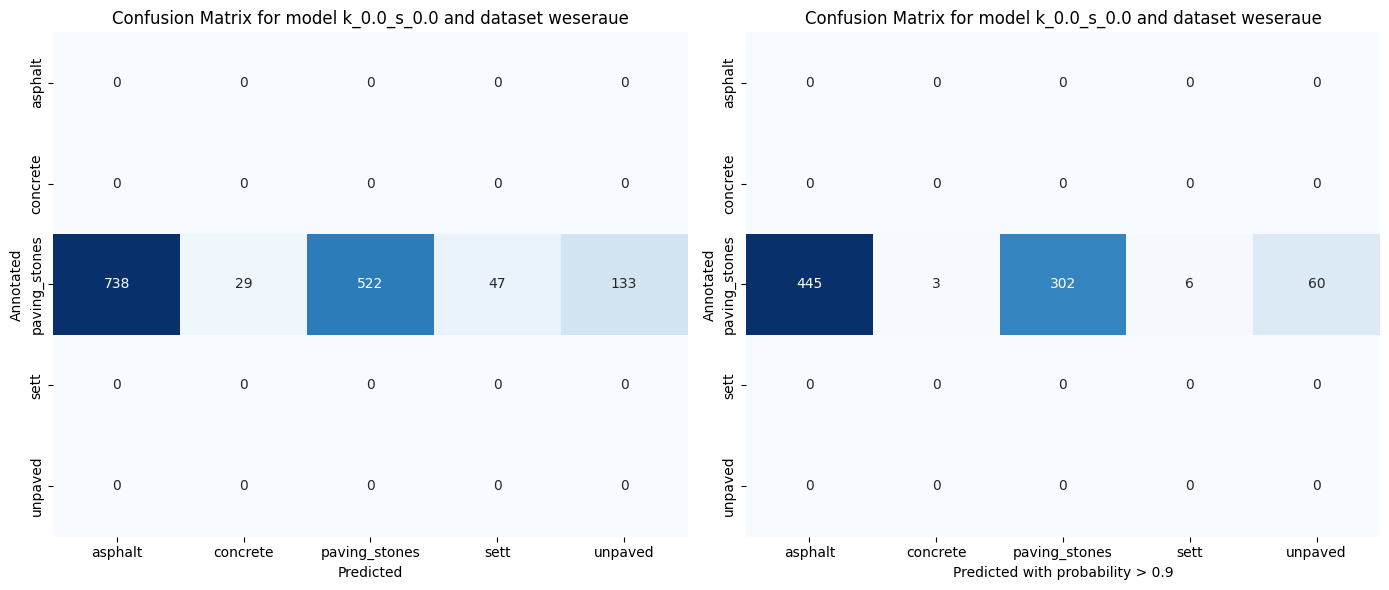

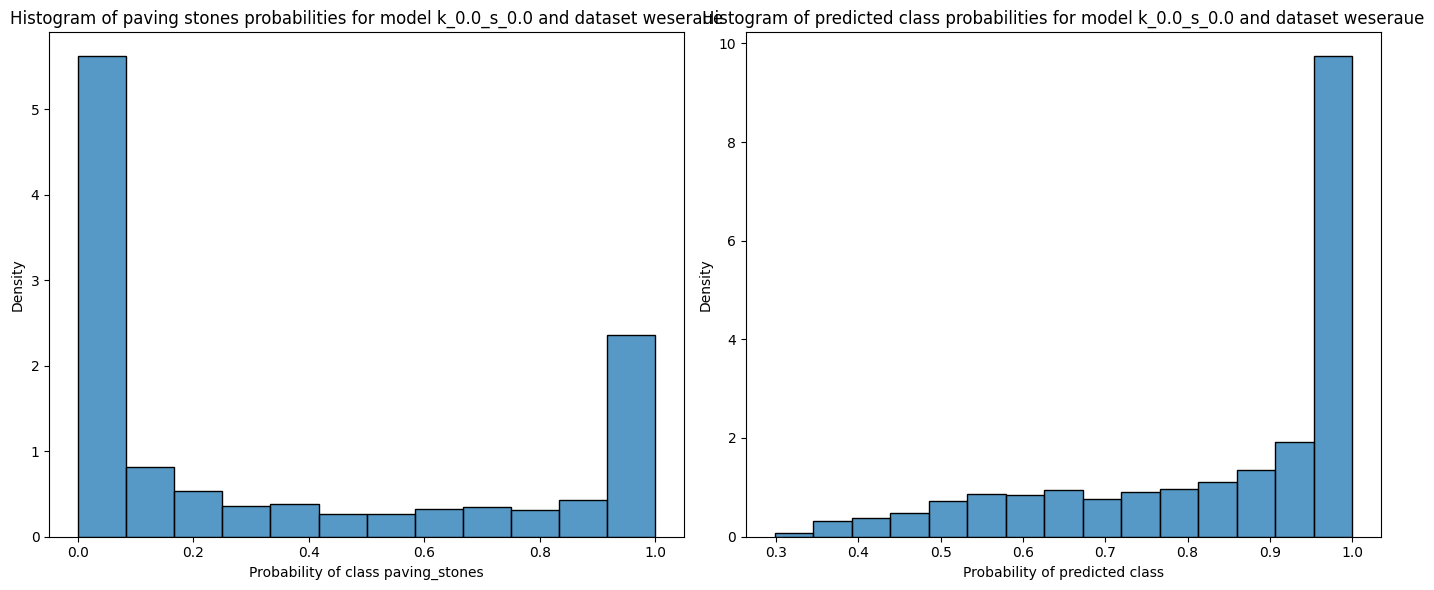

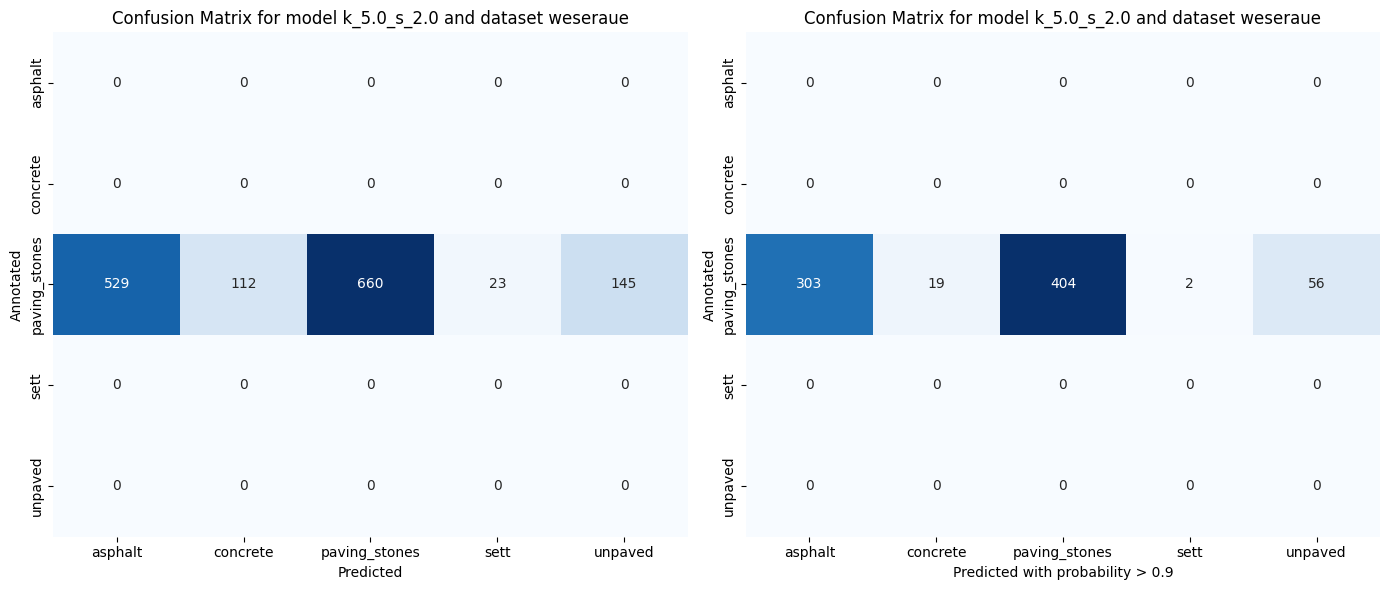

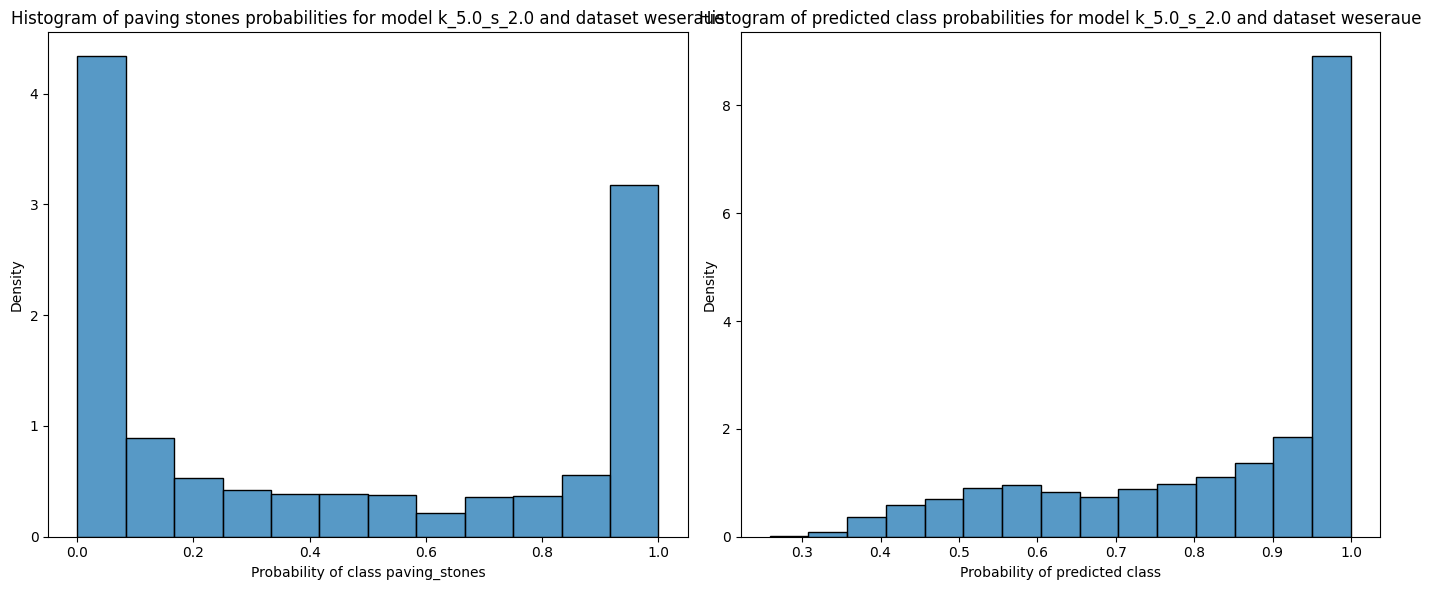

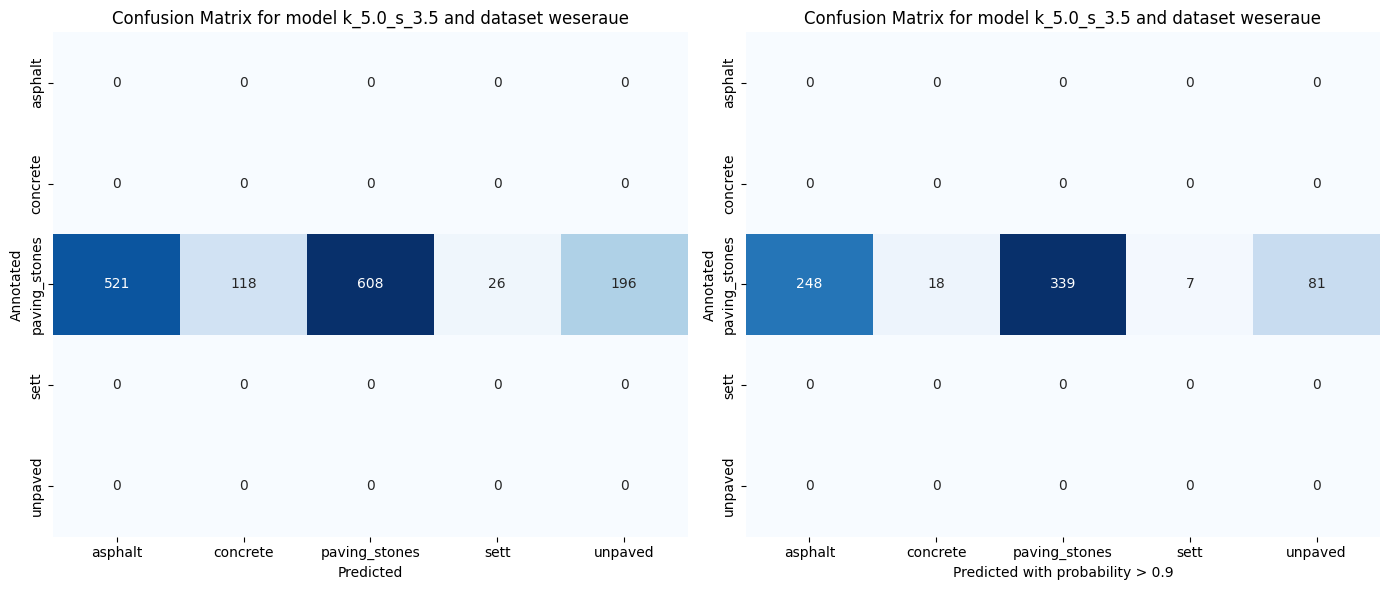

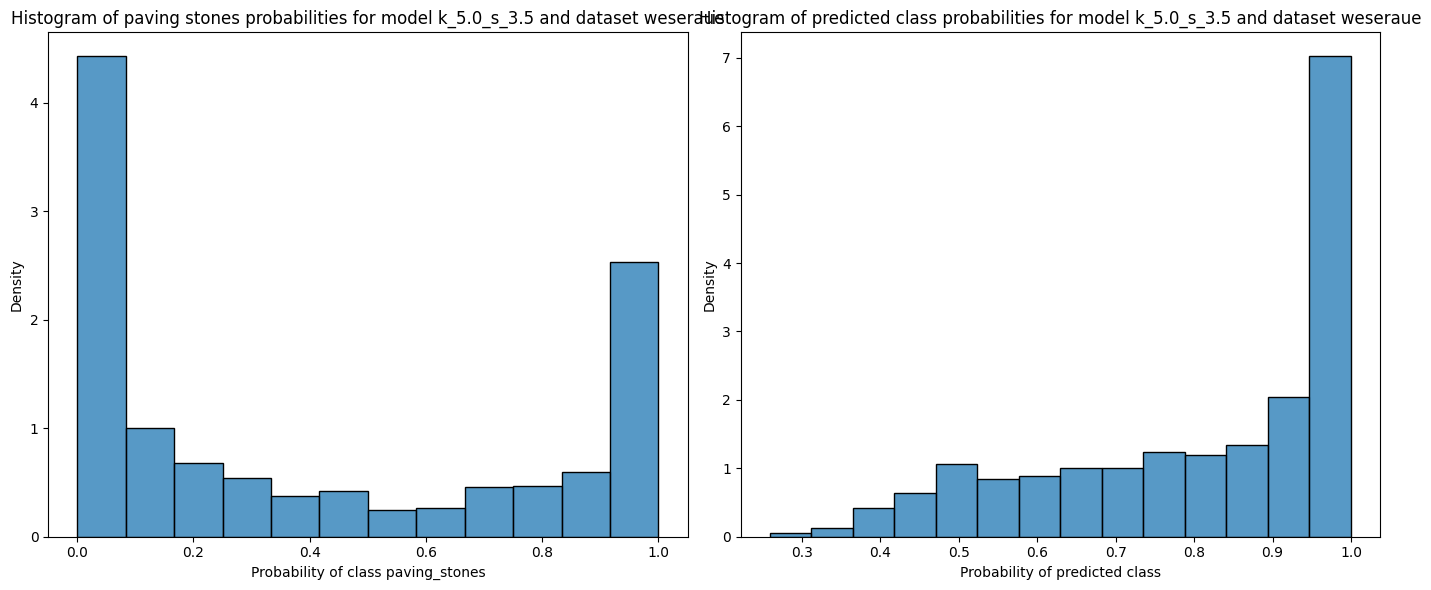

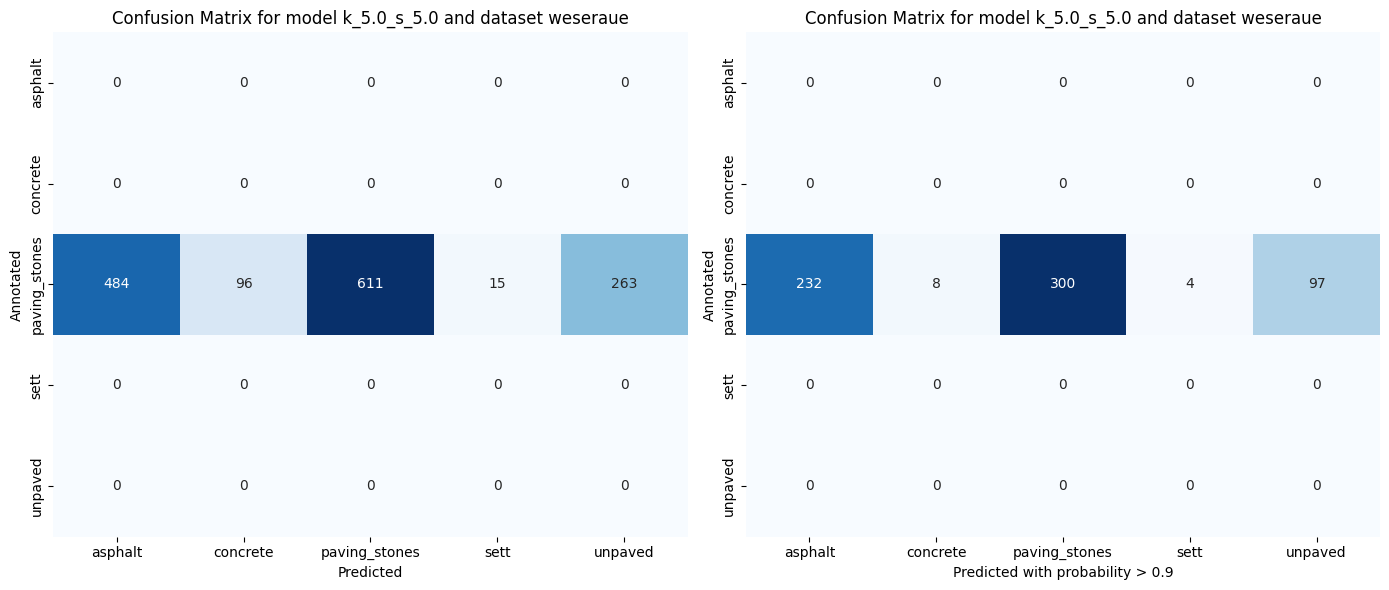

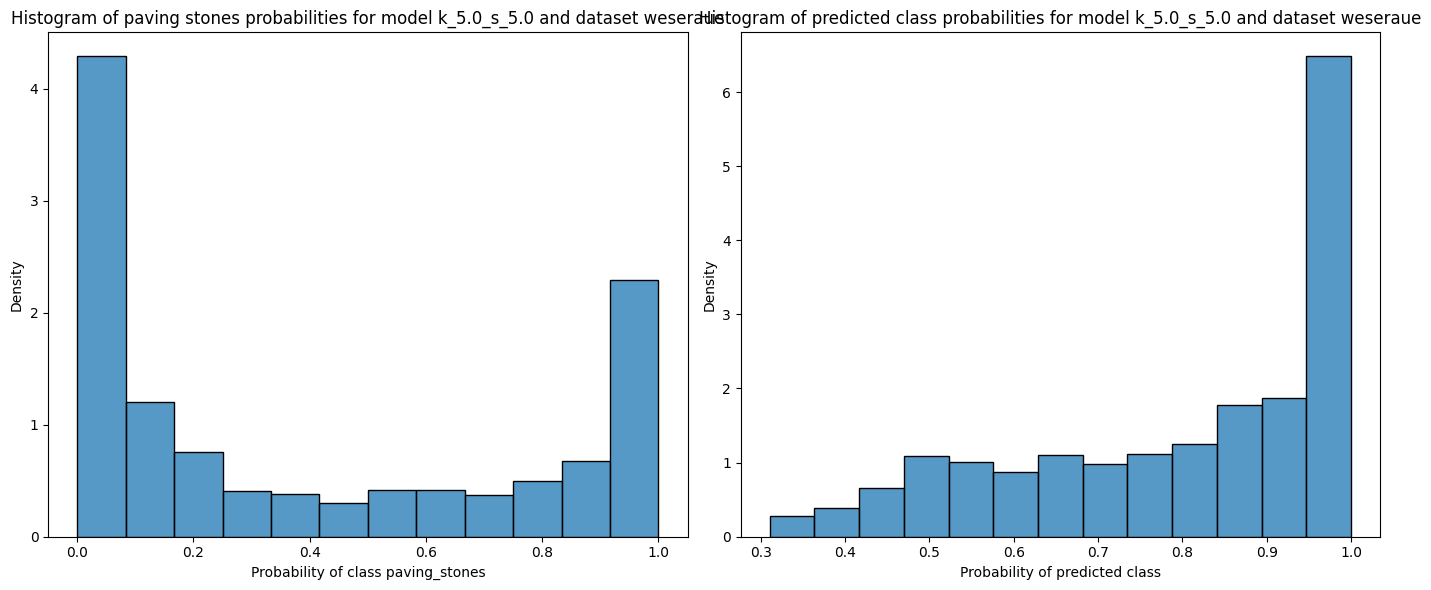

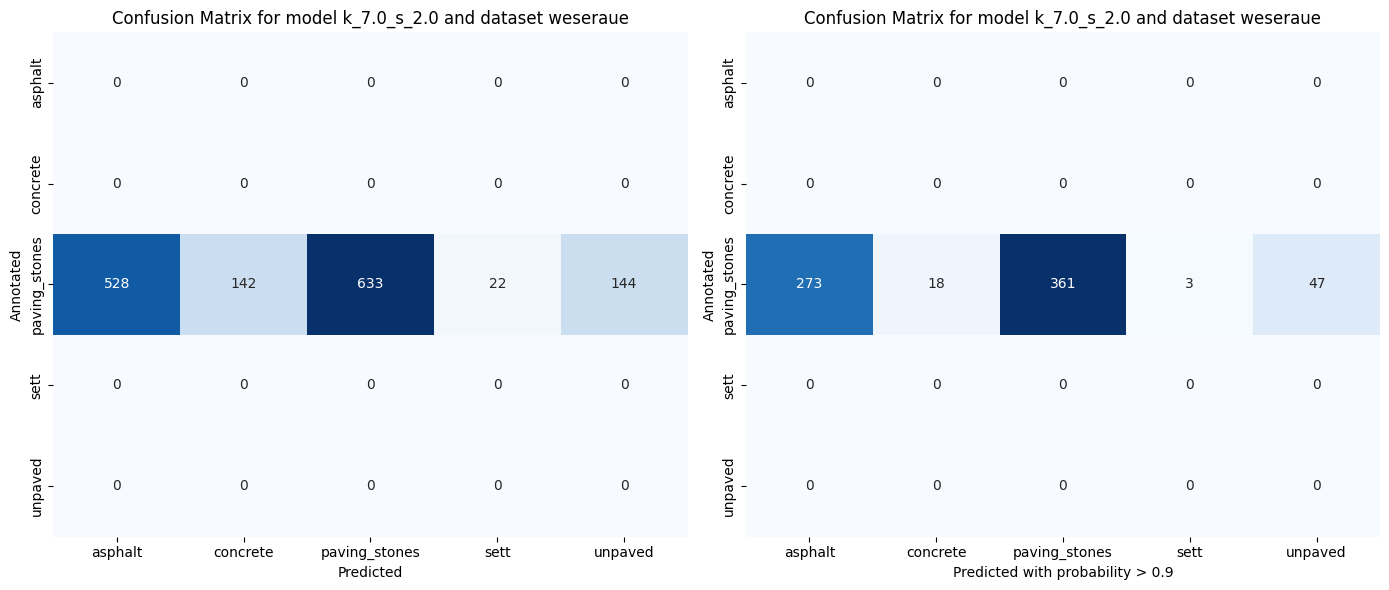

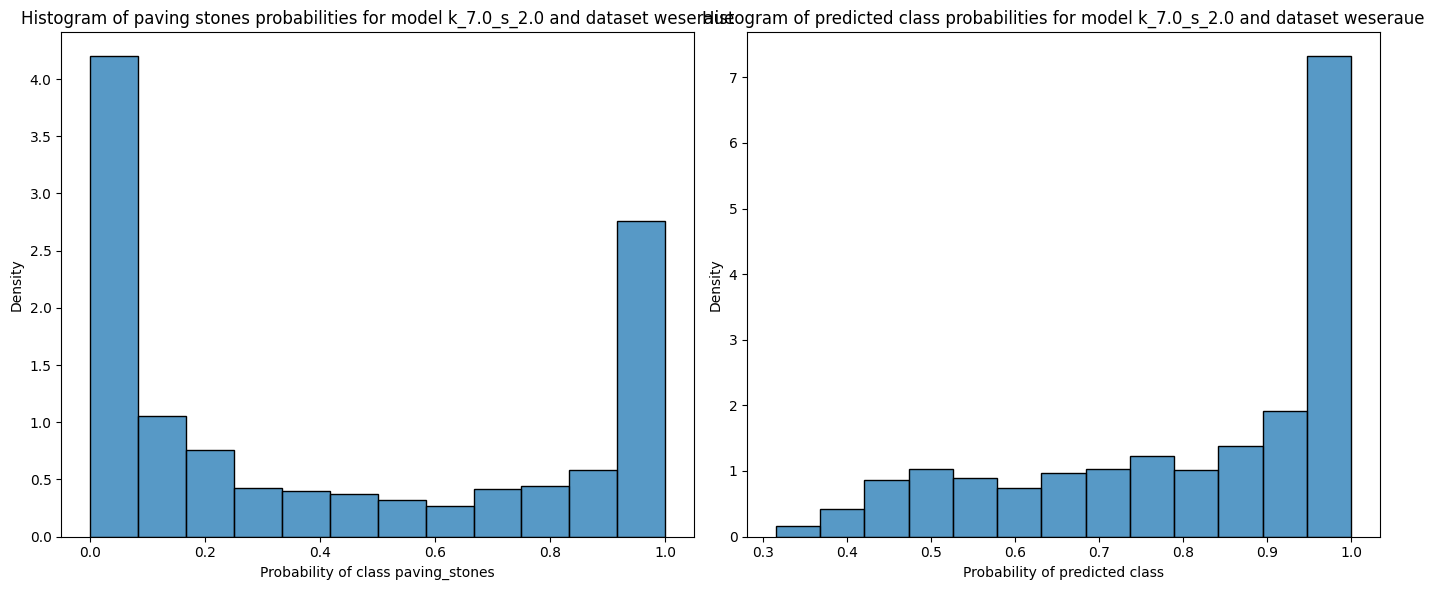

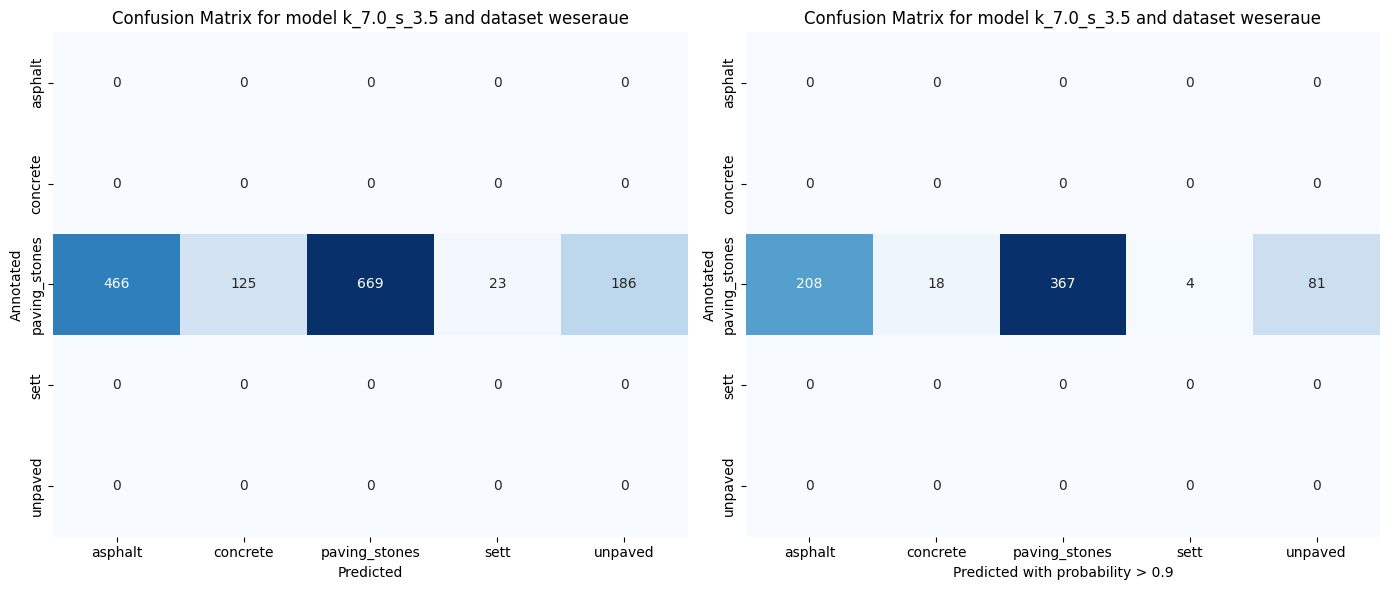

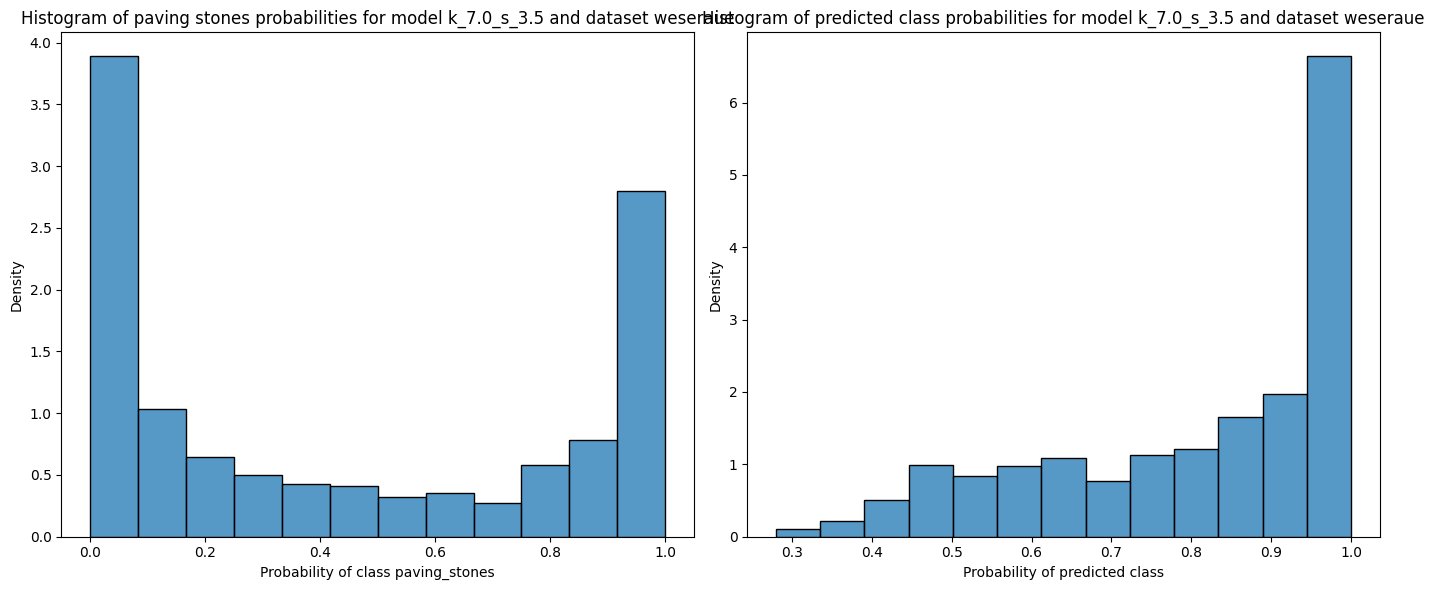

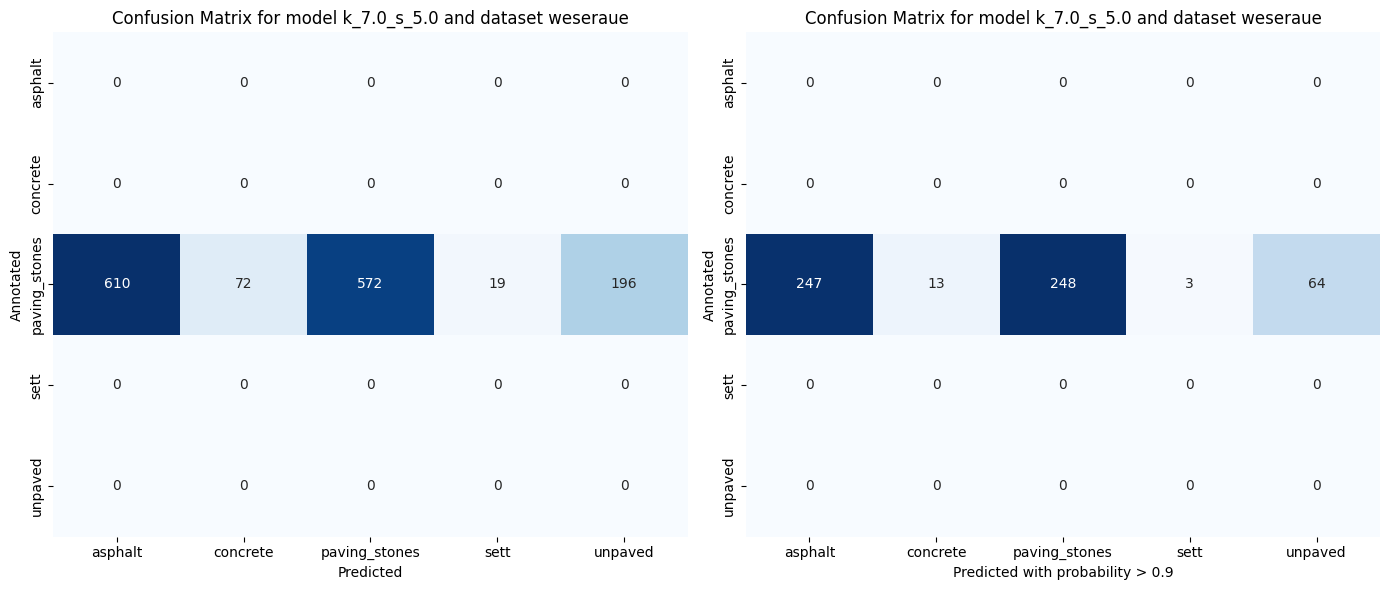

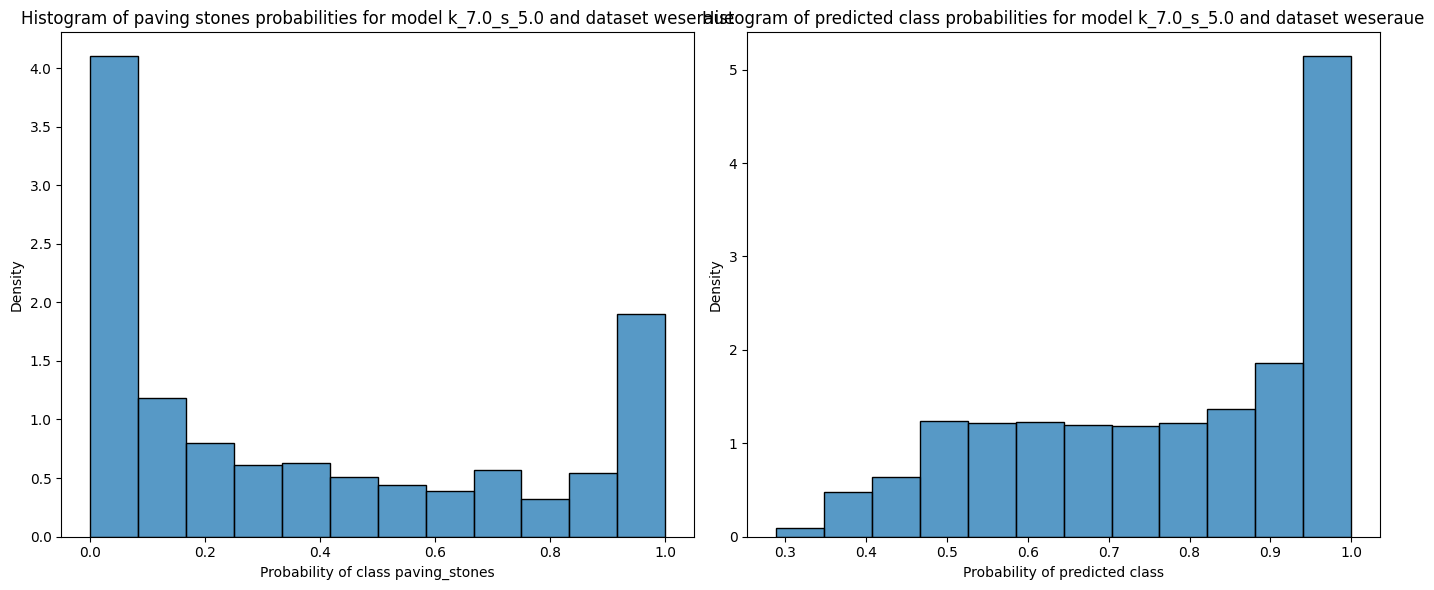

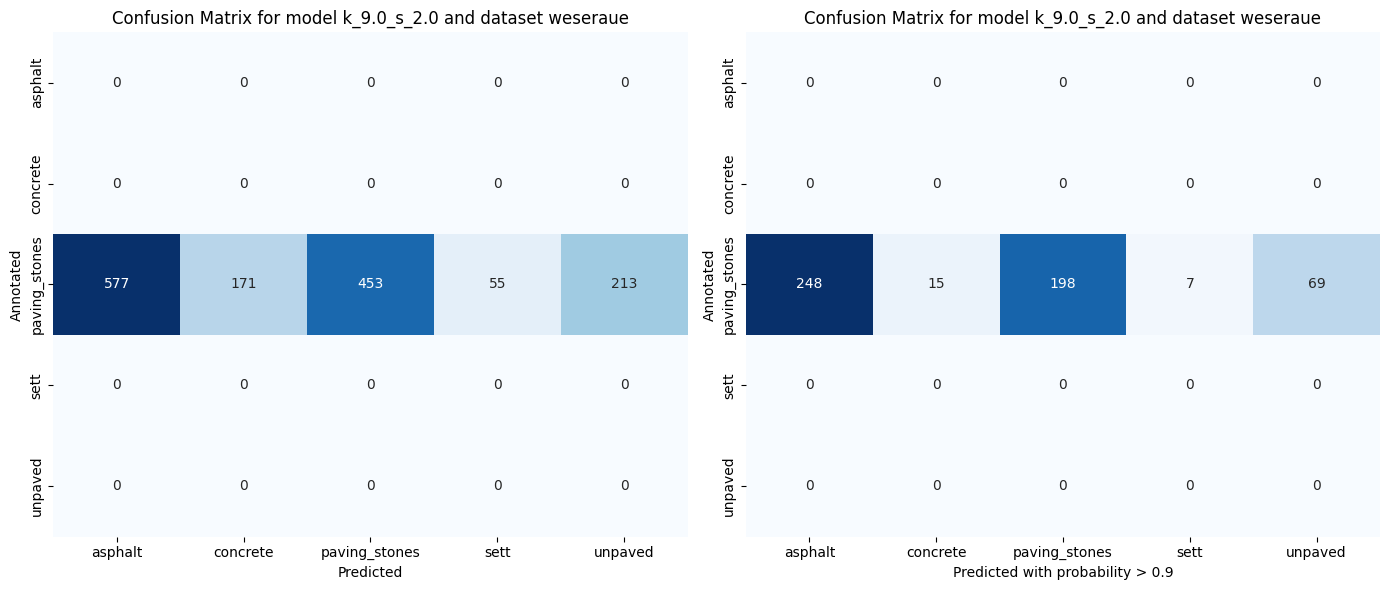

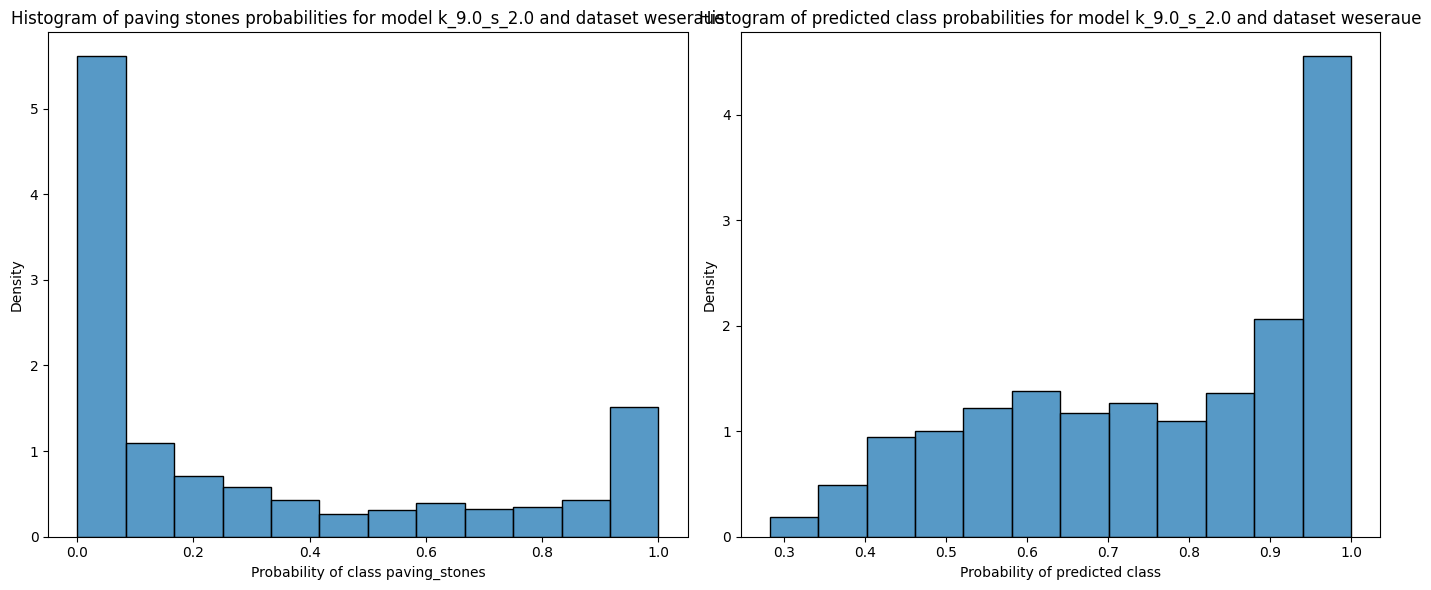

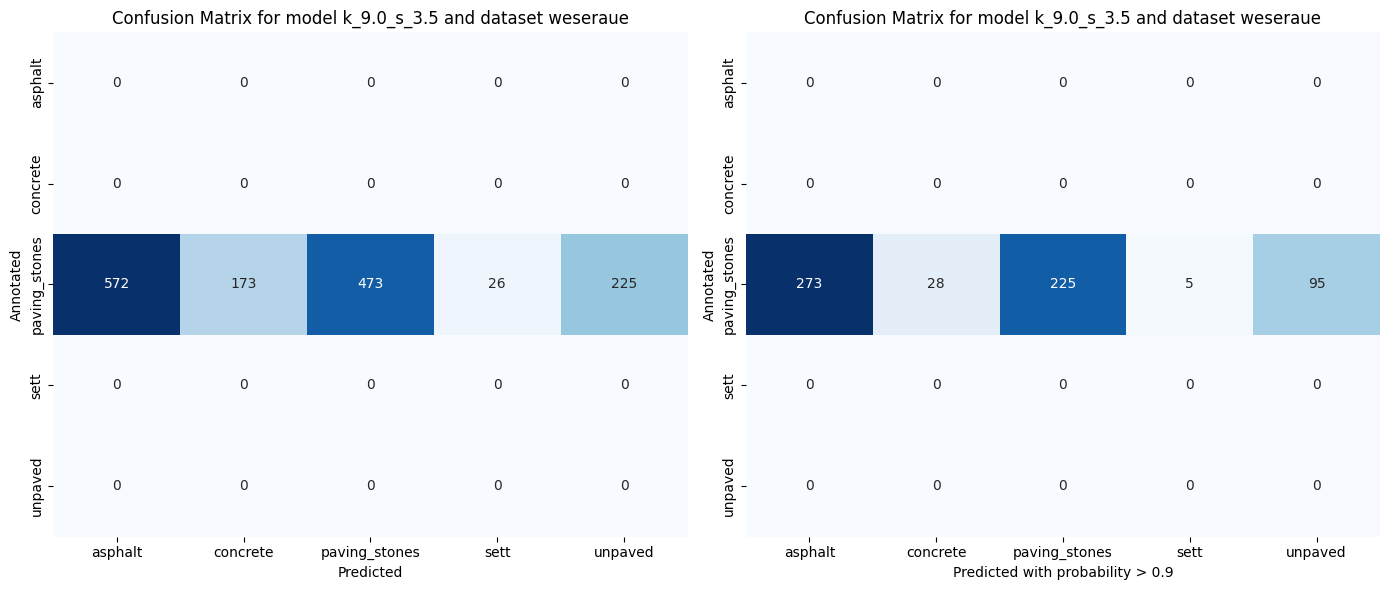

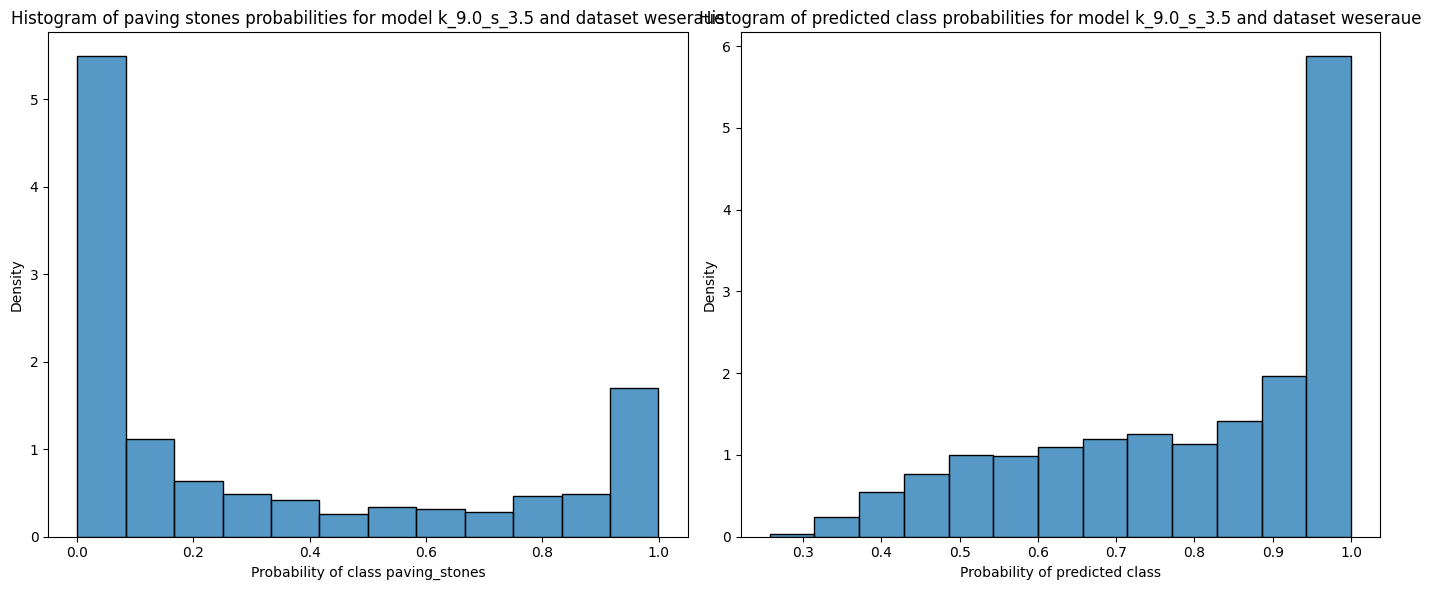

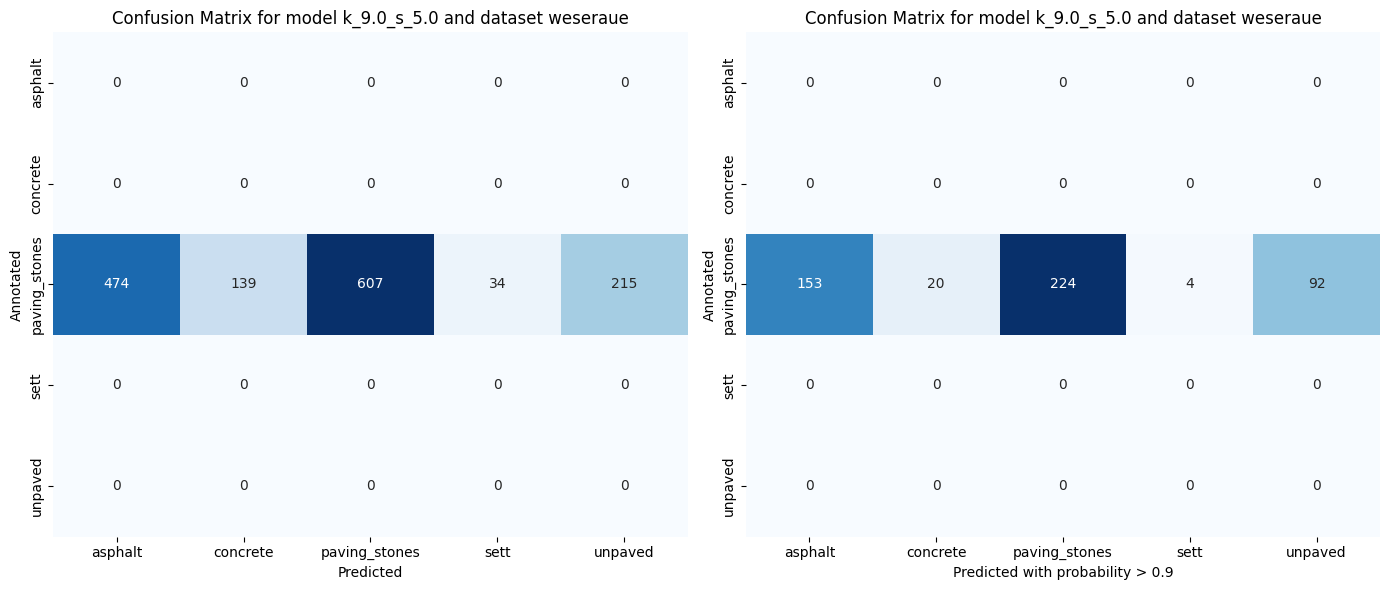

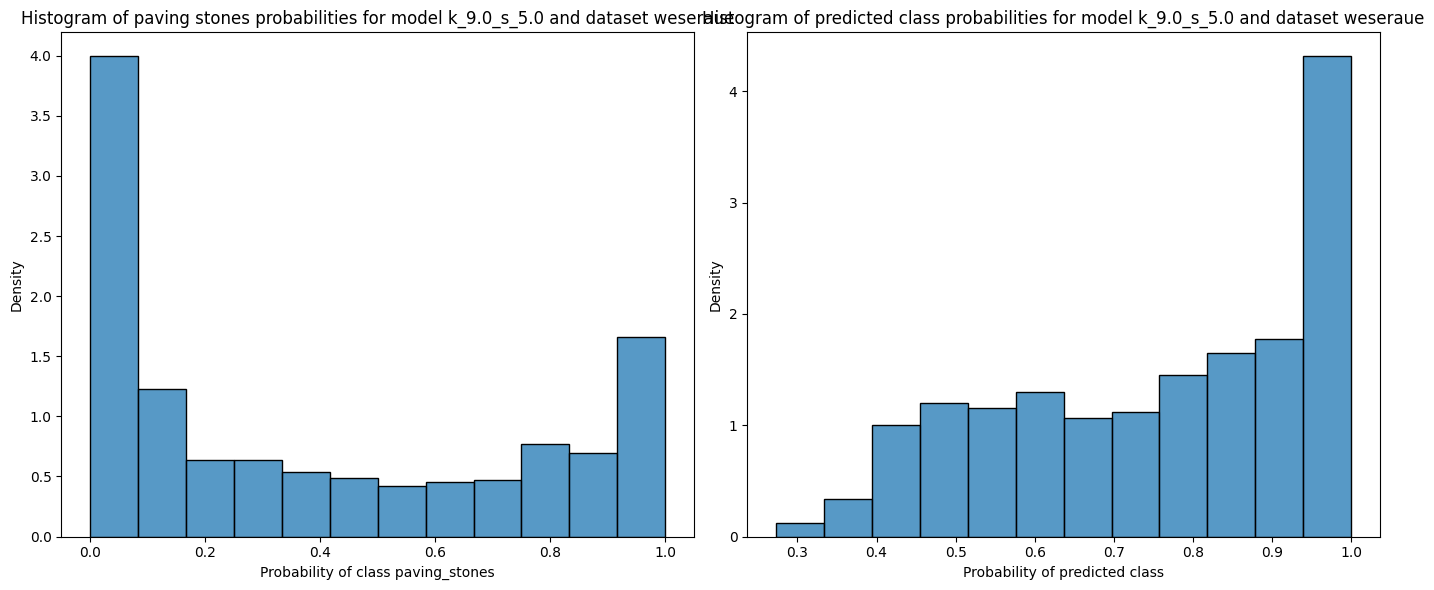

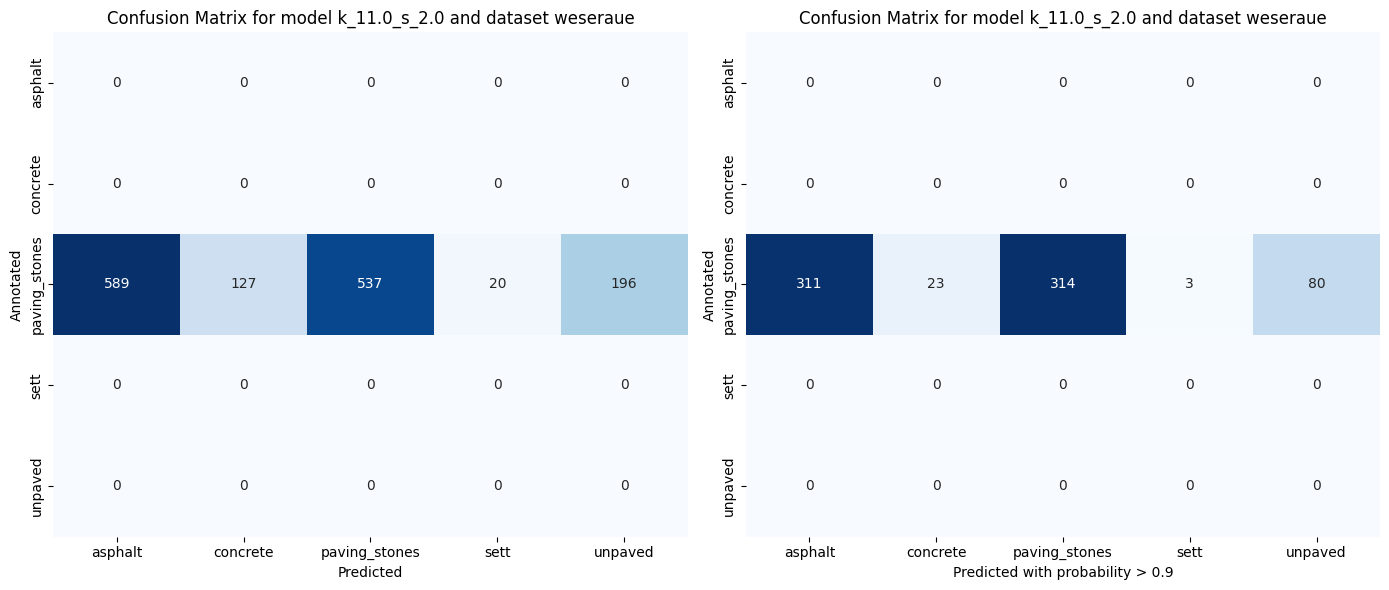

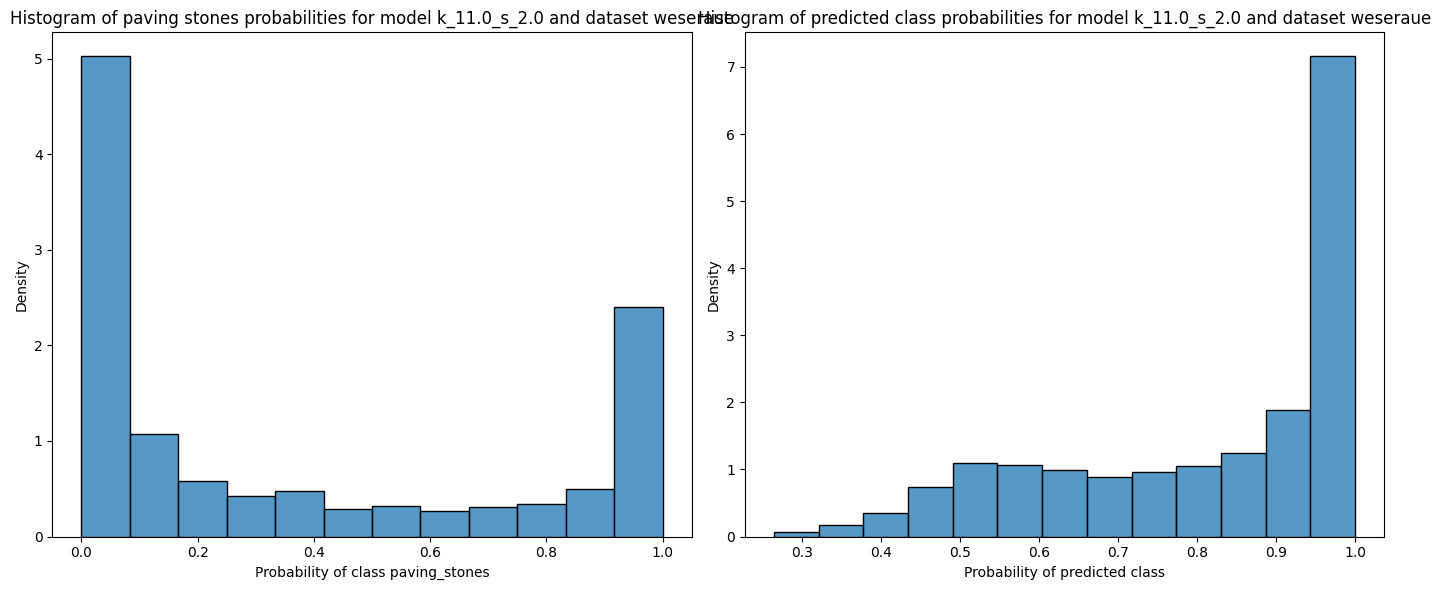

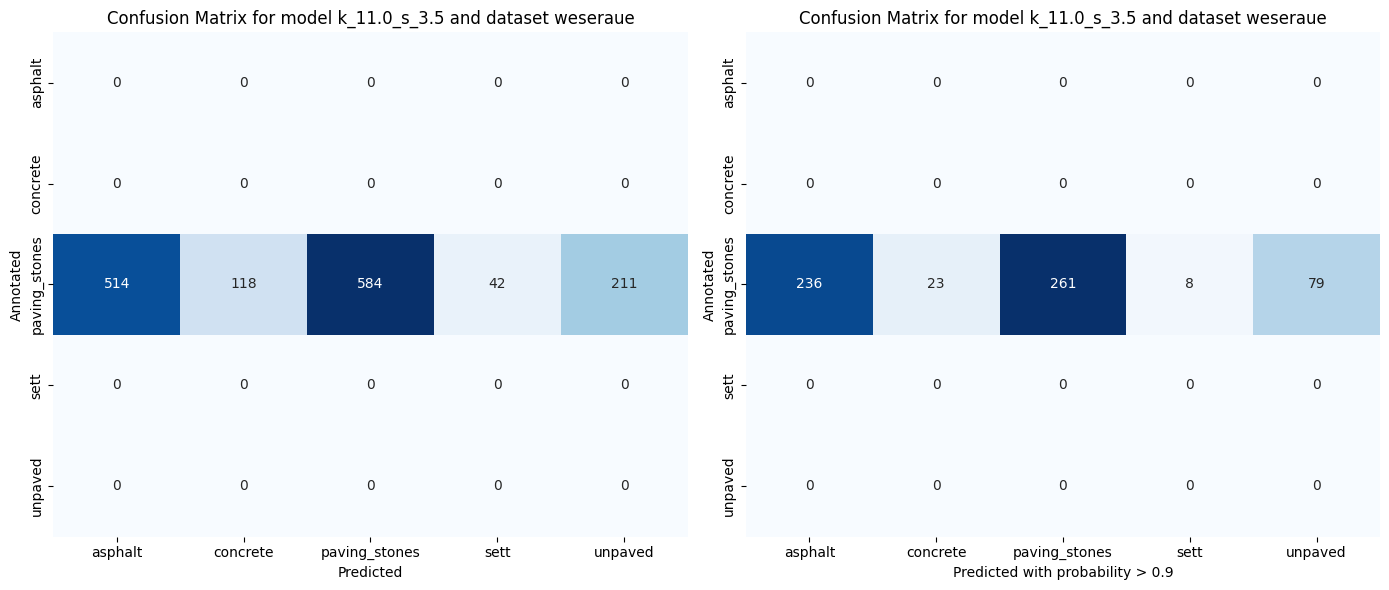

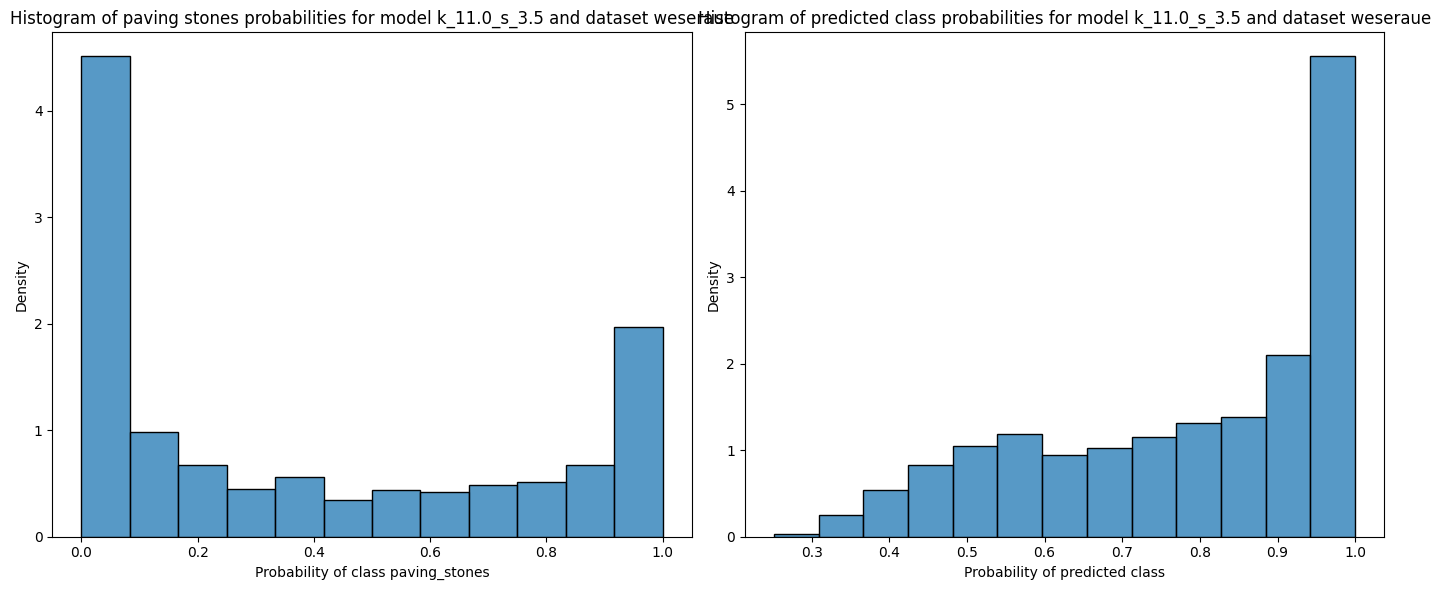

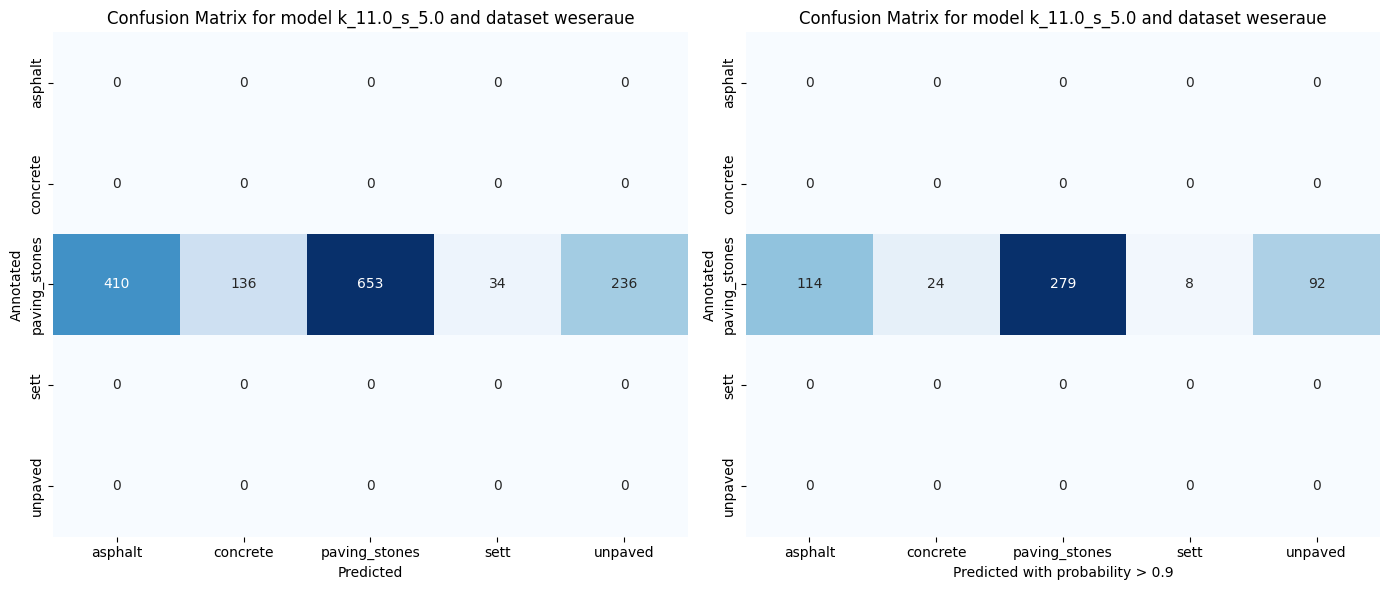

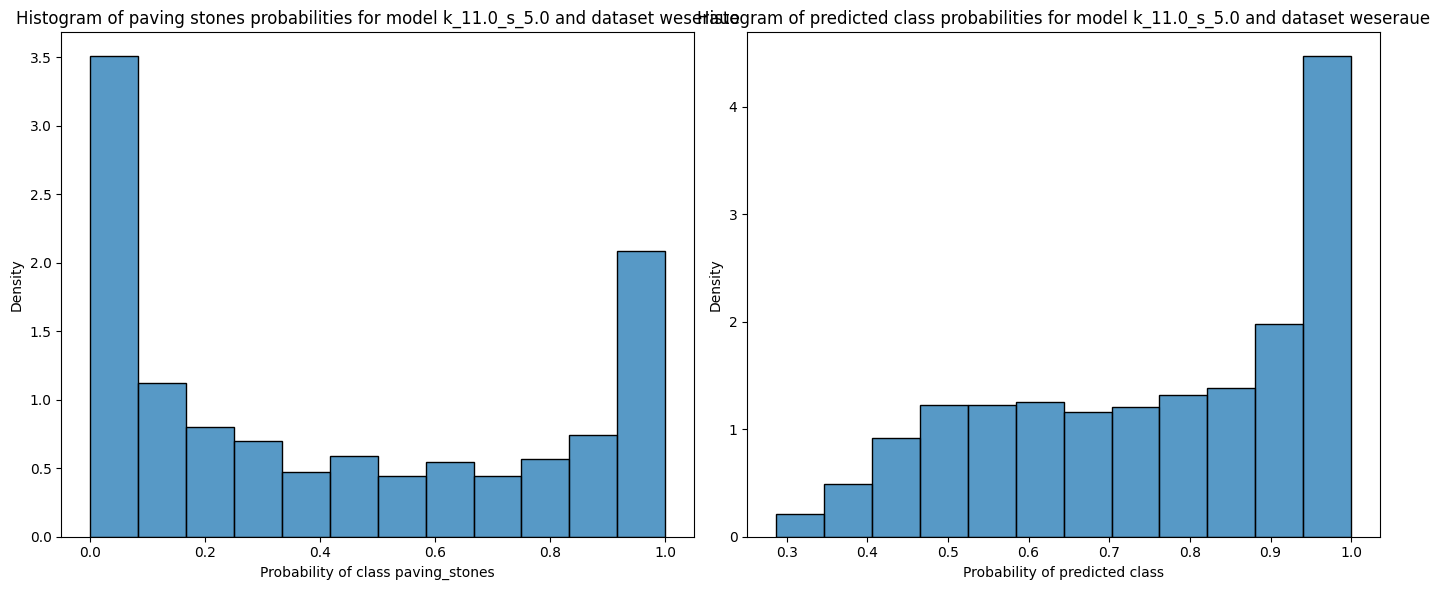

In [81]:
for _, model_row in df_blur.iterrows():

        index_y = df_blur.index[(df_blur["kernel"]==model_row["kernel"]) & (df_blur_orig["sigma"]==model_row["sigma"])][0]

        plot_conf_matrix_2(cm_valid[index_y, :, :], cm_valid_high_conf[index_y, :, :], f"k_{model_row['kernel']}_s_{model_row['sigma']}", "weseraue")

        column = f"model_k_{model_row['kernel'] if model_row['kernel'] != 0 else None}_s_{model_row['sigma'] if model_row['sigma'] != 0 else None}"

        plot_prob_hist(classification[f"{column}_ps_prob"], classification[f"{column}_prob"], f"k_{model_row['kernel']}_s_{model_row['sigma']}", "weseraue")

In [56]:
# k_5 s_2 & k_11 s_5

# for _, model_row in df_blur.iterrows():

#         index_y = df_blur.index[(df_blur["kernel"]==model_row["kernel"]) & (df_blur_orig["sigma"]==model_row["sigma"])][0]

#         plot_conf_matrix(cm_valid[index_y, :, :], f"k_{model_row['kernel']}_s_{model_row['sigma']}", "weseraue")

In [57]:
# for _, model_row in df_blur.iterrows():

#         index_y = df_blur.index[(df_blur["kernel"]==model_row["kernel"]) & (df_blur_orig["sigma"]==model_row["sigma"])][0]

#         plot_conf_matrix(cm_valid_high_conf[index_y, :, :], f"k_{model_row['kernel']}_s_{model_row['sigma']}", "weseraue, limited to high confidence predictions")

In [ ]:
# high confidence only

# Misclassified

In [ ]:
# # all images that were incorrectly classified
# misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

# misclassification = misclassification.sort_values("image_id")
# misclassification.reset_index( inplace=True)
# misclassification[["image_id", "is_in_validation", 
#                    "surface_true", "surface_label_pred", "quality_label_true"]
#                    ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)